# Causal Inference / Hubungan Sebab Akibat Terhadap Resignation Employee

In [1]:
# !pip install pyforest

In [2]:
# !pip install shap

#### Causal Inference package


In [3]:
# !pip install econml

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os

# untuk menjelaskan atau memahami bagaimana model membuat prediksi dengan top feature
import shap

In [6]:
from pyforest         import *
from lightgbm         import LGBMClassifier
from sklearn.compose  import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
from econml.solutions.causal_analysis import CausalAnalysis

In [8]:
from google.colab import drive

In [9]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/HR_Employees.csv')

Mounted at /content/drive


<IPython.core.display.Javascript object>

In [10]:
df.columns

Index(['tingkat_kepuasan', 'evaluasi_terakhir', 'jumlah_proyek',
       'rata-rata_jam_bulan', 'waktu_spent_for_perusahaan', 'Kecelakaan_kerja',
       'resign', 'promosi_5tahun_terakhir', 'Departemen', 'gaji'],
      dtype='object')

In [11]:
df

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,Departemen,gaji
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [12]:
gaji_mapping = {'low': 0, 'medium': 1, 'high': 2}
df['gaji']   = df['gaji'].map(gaji_mapping)

In [13]:
X            = df.drop('resign', axis=1)
y            = pd.DataFrame(df['resign'])

<IPython.core.display.Javascript object>

In [14]:
X

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,promosi_5tahun_terakhir,Departemen,gaji
0,0.38,0.53,2,157,3,0,0,sales,0
1,0.80,0.86,5,262,6,0,0,sales,1
2,0.11,0.88,7,272,4,0,0,sales,1
3,0.72,0.87,5,223,5,0,0,sales,0
4,0.37,0.52,2,159,3,0,0,sales,0
...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,0
14995,0.37,0.48,2,160,3,0,0,support,0
14996,0.37,0.53,2,143,3,0,0,support,0
14997,0.11,0.96,6,280,4,0,0,support,0


In [15]:
y

,resign
0,1
1,1
2,1
3,1
4,1
...,...
14994,1
14995,1
14996,1
14997,1


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

<IPython.core.display.Javascript object>

In [17]:
print('Data Latih X', X_train.shape)
print('Data Test X', X_test.shape)
print('Data Latih y', y_train.shape)
print('Data Test X', y_test.shape)

Data Latih X (11999, 9)
Data Test X (3000, 9)
Data Latih y (11999, 1)
Data Test X (3000, 1)


In [18]:
categorical = []
for col, value in X_train.items():
    if value.dtype == "object":
        categorical.append(col)

numerical = X_train.columns.difference(categorical)

In [19]:
categorical

['Departemen']

In [20]:
numerical

Index(['Kecelakaan_kerja', 'evaluasi_terakhir', 'gaji', 'jumlah_proyek',
       'promosi_5tahun_terakhir', 'rata-rata_jam_bulan', 'tingkat_kepuasan',
       'waktu_spent_for_perusahaan'],
      dtype='object')

### Membuat pipeline untuk sekaligus transformasi data
- mengisi NaN dengan median dan NaN


In [21]:
transormasi_numerik   = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

transormasi_kategorik = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="mmissing")),
                                        ("onehot", OneHotEncoder(handle_unknown="error", drop="first"))])

transformasi          = ColumnTransformer(transformers=[("num", transormasi_numerik, numerical),
                                                   ("cat", transormasi_kategorik, categorical)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# keseluruhan pipeline

clf = Pipeline(steps=[("preprocessor", transformasi),
                      ("classifier", LGBMClassifier())])

### Interpretasi Korelasi antar Variabel menggunakan Shap
memahami fitur-fitur penting utama untuk memprediksi resign karyawan caranya secara internal menggunakan shap.



- disini aku coba mencari parameter kombinasi terbaik, yaitu learning ratenya. Pada gradient boost yaitu LightGBM (pada kode preprocessing sebelumnya)


In [23]:
parameter_gb = {"classifier__learning_rate": [0.1, 0.05, 0.01],
                "classifier__max_depth": [3, 5, 10],
                "classifier__num_leaves": [31, 62, 127]}

terbaik      = GridSearchCV(clf, param_grid=parameter_gb, n_jobs=-1)

<IPython.core.display.Javascript object>

In [24]:
terbaik.fit(X_train, y_train)
terbaik.best_params_

[LightGBM] [Info] Number of positive: 2870, number of negative: 9129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 11999, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239187 -> initscore=-1.157144
[LightGBM] [Info] Start training from score -1.157144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 10,
 'classifier__num_leaves': 127}

In [25]:
# Tujuan: Visualisasi top feature

model_latih       = terbaik.best_estimator_["classifier"]
transformer_latih = terbaik.best_estimator_["preprocessor"]

# nama fitur/variabel
nama_kolom = numerical.tolist()
nama_kolom += (terbaik.best_estimator_["preprocessor"]
               .transformers_[1][1]
               .steps[1][1]
               .get_feature_names_out(categorical)
               .tolist()
)

In [26]:
# Visualisasi top feature dengan menggunakan Tree Explainer

bg  = shap.maskers.Independent(transformer_latih
                              .transform(X_train), max_samples=2000)

isi = shap.TreeExplainer(model_latih,
                         data=bg,
                         feature_names=nama_kolom)

In [27]:
nilai_shap = isi(transformer_latih.transform(X_test)) #

100%|===================| 2997/3000 [08:42<00:00]       

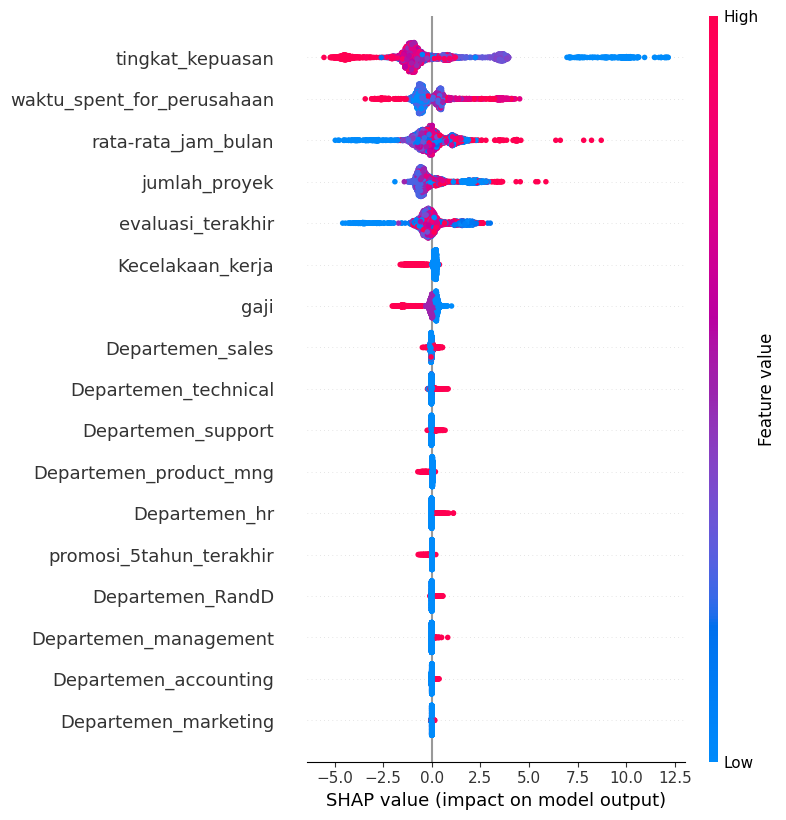

In [28]:
shap.summary_plot(nilai_shap, transformer_latih.transform(X_test))

- semakin tinggi nilai SHAP yang dimiliki oleh suatu fitur, maka variabel tersebut memilki korelasi yang bagus.

Berdasarkan hasil visualisasi nilai SHAP diatas yang dirutukan berdasarkan importances masing-masing variabel. Didapatkan terdapat beberapa variabel yang memiliki nilai atau korelasi yang bagus, seperti pada 5 fitur terpenting teratas yaitu tingkat kepuasan karyawan, waktu yang dihabiskan karyawan pada perusahaan, rata-rata total jam dalam kerja perbulan, jumlah proyek yang ditangani, waktu evaluasi pekerjaan terakhir memiliki kemungkinan sangat tinggi atau sangat berpengaruh terhadap karyawan akan resign, dan jumlah gaji. Namun tentu saja hal ini tidak berarti adalah faktor pendorong yang secara langsung menyebabkan karyawan resign, mungkin aja ada variabel tersembunyi seperti **confounder** yang mempengaruhi fitur dan hasil teratas. Sebagai contoh, mungkin terdapat beberapa jenis departmen yang memiliki lingkungan kurang kondusif sehingga tidak dapat mencapai tujuan atau suatu karyawan tidak nyaman dalam lingkungan tersebut, sehingga menyebabkan karyawan resign.

Untuk mengatasi kemungkinan adanya variabel pengganggu tersebut, kita bisa melakukan perbaikan yang sesuai, kita bisa melatih model yang berbeda supaya mampu mengendalikan semua variabel tersembunyi (confounder) yang mungkin terjadi dan mempelajari efek sebab akibat (causal effect) untuk fitur yang diberikan. Solusi untuk permasalahan tersebut ternyata sudah ada tekniknya yaitu Tools dalam Causal Interpretation yang pertama-tama akan menjelaskan korelasi sebab akibat atau causal relationship terhadap 5 fitur teratas.

### Causal Interpretation

#### Direct Causal Effect --  Apakah Fitur Teratas Juga Memiliki Korelasi Langsung Terhadap Variabe Outcome?


In [29]:
klasifikasi        = True
k                  = 5

# top k fitur teratas

vals               = np.abs(nilai_shap.values).mean(0)

feature_importance = pd.DataFrame(list(zip(nilai_shap.feature_names, vals)),
                                  columns=["features", "importance"])

feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)

top_fitur          = feature_importance.iloc[:k]["features"]

top_fitur          = [i.split("_")[0] for i in top_fitur]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
top_fitur

['tingkat', 'waktu', 'rata-rata', 'jumlah', 'evaluasi']

In [31]:
X_train.columns

Index(['tingkat_kepuasan', 'evaluasi_terakhir', 'jumlah_proyek',
       'rata-rata_jam_bulan', 'waktu_spent_for_perusahaan', 'Kecelakaan_kerja',
       'promosi_5tahun_terakhir', 'Departemen', 'gaji'],
      dtype='object')

In [32]:
top_fitur_full = [col for col in X_train.columns if any(feat in col for feat in top_fitur)]

In [33]:
top_fitur_full

['tingkat_kepuasan',
 'evaluasi_terakhir',
 'jumlah_proyek',
 'rata-rata_jam_bulan',
 'waktu_spent_for_perusahaan']

In [34]:
categorical

['Departemen']

In [35]:
causal = CausalAnalysis(top_fitur_full,
                        categorical,
                        heterogeneity_inds=None,
                        classification=True,
                        nuisance_models="automl",
                        heterogeneity_model="forest",
                        n_jobs=-1,
                        random_state=123)

causal.fit(X_train, y_train.values)

[LightGBM] [Info] Number of positive: 1913, number of negative: 6086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 7999, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239155 -> initscore=-1.157318
[LightGBM] [Info] Start training from score -1.157318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [36]:
# cause-and-effect relationships between variables.
rangkuman = causal.global_causal_effect(alpha=0.05) # nilai signifikan biasanya 0.05
rangkuman

,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,,,,,,
tingkat_kepuasan,-0.045034,0.136332,-0.330329,0.741151,-0.312240,0.222172
evaluasi_terakhir,0.047186,0.129927,0.363173,0.716476,-0.207467,0.301839
jumlah_proyek,0.001923,0.014077,0.136580,0.891363,-0.025669,0.029514
rata-rata_jam_bulan,0.000230,NaN,NaN,NaN,0.000230,0.000230
waktu_spent_for_perusahaan,0.019013,0.013324,1.426913,0.153605,-0.007103,0.045128


Hasil evaluasi sepertinya tidak terlalu bagus dan tidak terlalu buruk jika dilihat dari nilai point, dan ci_lower dan juga ci_upper. (ada beberapa nilai p_value yang kosong).

-  **point**: estimasi titik dari efek kausal langsung untuk setiap fitur. Misalnya, untuk tingkat_kepuasan, estimasi efek kausalnya adalah -0.045034. Peningkatan satu unit dalam tingkat_kepuasan diperkirakan akan mengurangi nilai target sebesar 0.045034 unit, dengan asumsi nilai negatif menunjukkan penurunan.

- **stderr**: Standar error dari estimasi efek kausal. Mengukur seberapa bervariasi estimasi titik tersebut. Standar error yang lebih kecil menunjukkan estimasi yang lebih akurat. Misalnya, untuk tingkat_kepuasan, standar errornya adalah 0.136332.

- **zstat**: Statistik z yang dihitung sebagai point / stderr. Digunakan untuk menguji hipotesis apakah efek kausal langsung dari fitur tersebut berbeda dari nol. Misalnya, untuk tingkat_kepuasan, zstat adalah -0.330329, menunjukkan bahwa estimasi efek kausalnya tidak signifikan berbeda dari nol.

- **p_value**: Nilai p dari uji hipotesis terkait efek kausal. Menunjukkan probabilitas memperoleh hasil yang sama ekstremnya dengan yang diamati jika hipotesis nol benar. Nilai p yang lebih kecil dari 0.05 biasanya menunjukkan bahwa efek kausalnya signifikan secara statistik. Misalnya, untuk tingkat_kepuasan, p_value adalah 0.741151, menunjukkan bahwa efek kausalnya tidak signifikan secara statistik.

- **ci_lower** dan **ci_upper**: Batas bawah dan atas dari interval kepercayaan 95% untuk estimasi efek kausal. Memberikan rentang nilai di mana kita percaya bahwa efek kausal sebenarnya terletak dengan tingkat keyakinan 95%. Misalnya, untuk tingkat_kepuasan, interval kepercayaan adalah dari -0.312240 hingga 0.222172.

In [37]:
# Fungsi evaluasi model causal analisis tersebut
def evaluasi(hasil_eval):
  xticks   = hasil_eval.index.get_level_values(0)
  lower    = hasil_eval["point"] - hasil_eval["ci_lower"]
  upper    = hasil_eval["ci_upper"] - hasil_eval["point"]

  xticks   = [
         "{}***".format(t)
         if p < 1e-6
         else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
         for t, p in zip(xticks, hasil_eval["p_value"])
      ]

  plot_judul = "Efek Kausal Langsung dari Setiap Fitur dengan Interval Confidence yaitu 95% atau 0.95, "
  plt.figure(figsize=(20, 7))

  plt.errorbar(
      np.arange(len(xticks)),
      hasil_eval["point"],
      yerr=[lower, upper],
      fmt="o",
      capsize=5,
      capthick=1,
      barsabove=True,
    )

  plt.xticks(np.arange(len(xticks)),
                       xticks,
                       rotation=45)

  plt.title(plot_judul)
  plt.axhline(0, color="r", linestyle="--", alpha=0.5)
  plt.ylabel("Rata-rata pengaruh terhadap variabel Treatment (ATE)")
  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

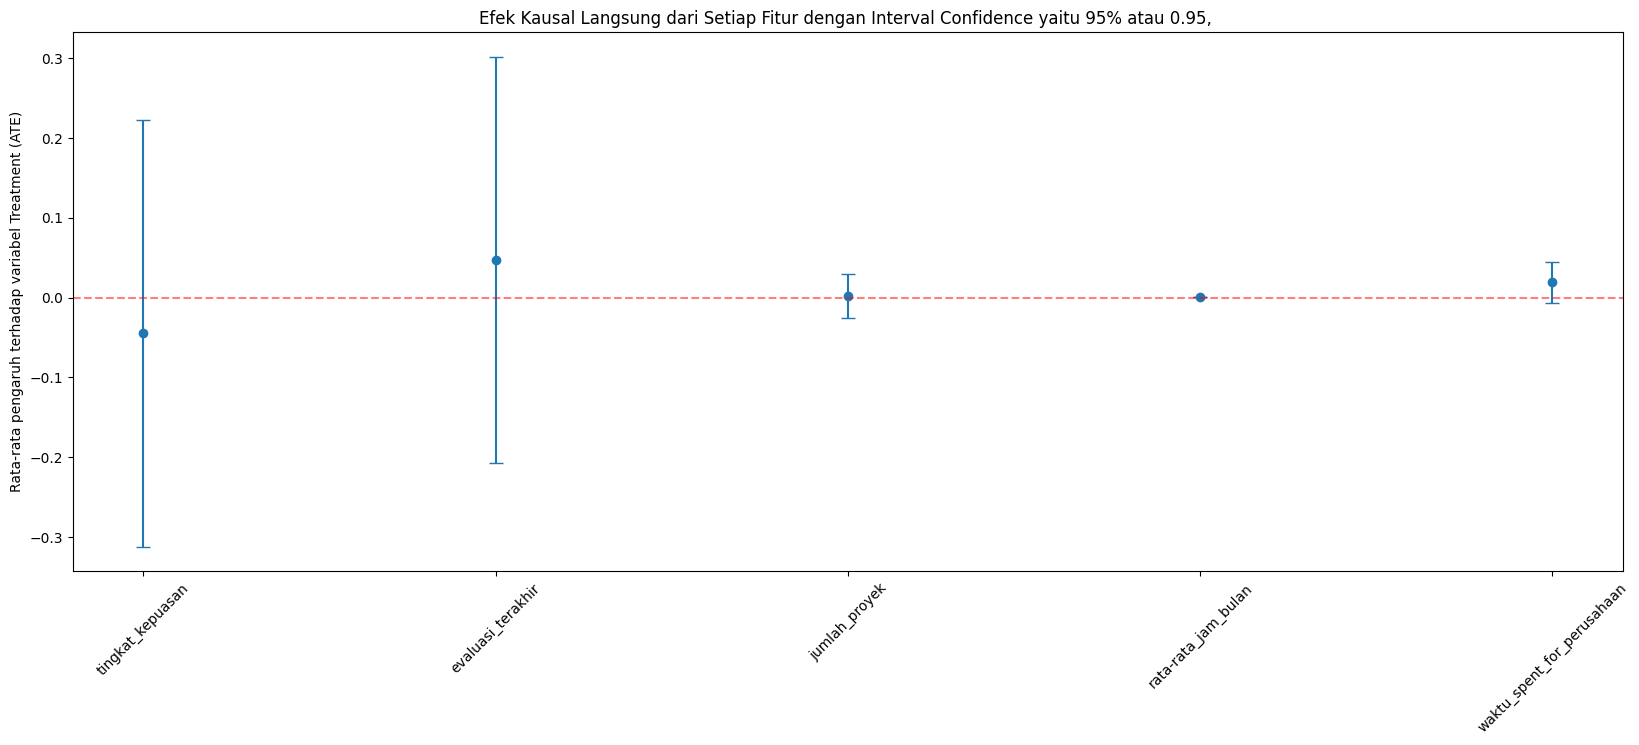

In [38]:
evaluasi(rangkuman)

#### Average Treatment Effect (ATE)
Dalam level populasi, ATE dapat didefinisikan dengan rumus:

ATE = E[Y(T = 1) — Y(T = 0)]

- Menghitung rata-rata kelompok Treatment. (top_fitur_full)
- Menghitung rata-rata kelompok Kontrol.
- ATE / Efek: Mengurangi rata-rata Treatment dengan rata-rata kontrol.


Dari tabel ringkasan dan plot evaluasi di atas, dapat dilihat bahwa arah dari causal effect atau arah efek sebab akibat tersebut cukup linear dan sejalan dengan arah korelasinya. Tapi fitur-fitur seperti **jumlah_proyek** dan **waktu_spent_for_perusahaan** mungkin saja merupakan prediktor terkuat tentang seberapa besar kemungkinan karyawan akan **resign**, namun aku belum yakin bahwa kedua fitur ini merupakan fitur yang pasti menandakan karyawan untuk **resign**.

Informasi tersebut diharapkan berguna untuk para manajer ketika ingin mencoba untuk membuat rencana untuk mengurangi tingkat resign karyawan, meningkatkan tingkat kepuasan karyawan, mempersiapkan lebih matang ketika melakukan evaluasi pekerjaan, mengerjakan atau mengalokasikan proyek yang terstruktur, dan juga mengoptimalkan waktu yang digunakan oleh karyawan terhadap perusahaan mungkin lebih efektif daripada hanya menaikan gaji / saham mereka.

### Bagaimana cara membuat rencana individual terstruktur dan matang untuk mengurangi tingkat resign?

Kita sudah mempelajari efek **ATE** dari setiap fitur teratas dari tingkat rata-rata keseluruhan. Namun, orang-orang dengan pengalaman kerja yang berbeda mungkin memiliki respon yang berbeda terhadap setiap alasan potensial diatas. Karena fitur-fitur yang berhubungan atau berkaitan dengan pengerjaan proyek tidak signifikan pada tingkat rata-rata fitur lainnya, aku jadi tertarik untuk menemukan sub-kelopmok yang akan merespons positif terhadap jumlah proyek yang dikerjakan. Jika berhasill menemukan sub-kelompok yang memiliki pengaruh signifikan terhadap pengerjaan proyek, kita dapat membantu para manajer untuk menyempurnakan strategi mereka dan membuat rencana individual terstruktur dan matang untuk karyawan yang berbeda-beda.

<IPython.core.display.Javascript object>

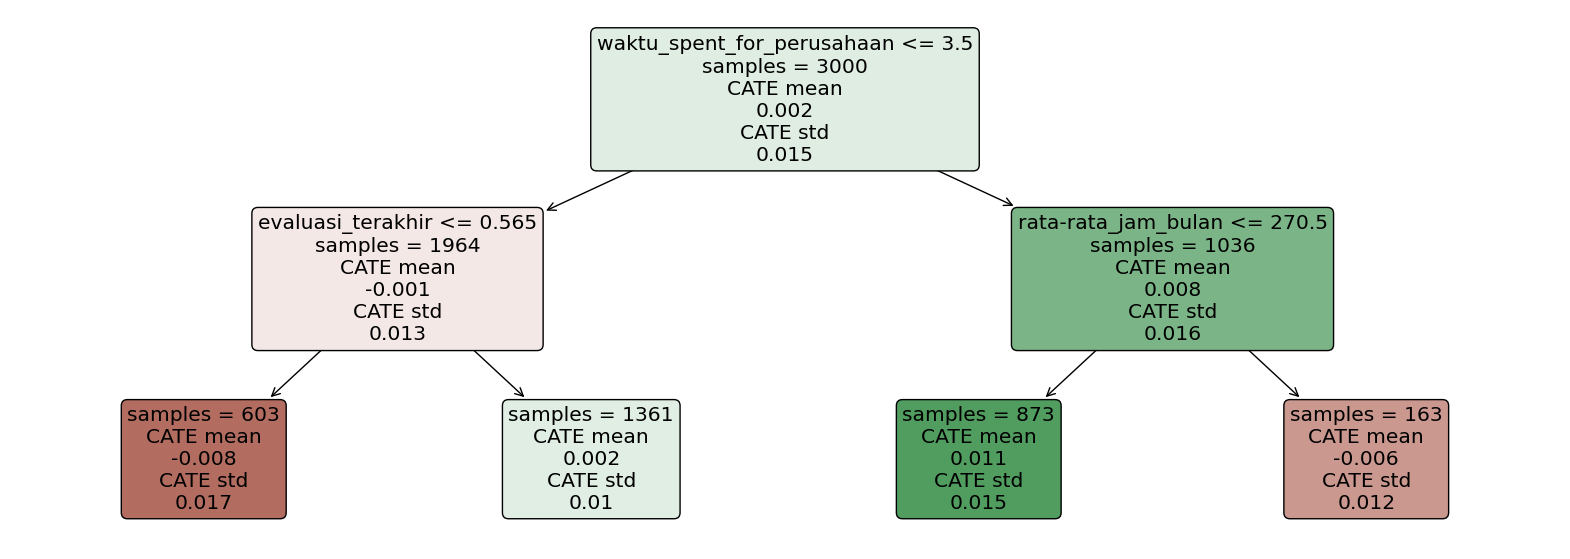

In [39]:
plt.figure(figsize=(20, 7))
causal.plot_heterogeneity_tree(
    X_test, "jumlah_proyek", max_depth=2, min_impurity_decrease=1e-7
)

#### CATE atau Conditional Average Treatment Effect
CATE (as mentioned, also known as heterogeneous treatment effect) is where the treatment effect varies across different subgroups.

Diagram heterogeneity_tree memberikan kita wawasan tentang bagaimana pengaruh kausal dari variabel **"jumlah_proyek"** dengan menggunakan CATE terhadap hasil bervariasi di antara subkelompok dalam data. Berdasarkan diagram yang dihasilkan maka dapat diambil kesimpulan bahwa:

Pengaruh Positif: Karyawan dengan waktu lebih singkat di perusahaan, evaluasi terakhir dengan hasil cukup tinggi, dan jam kerja bulanan rendah menunjukkan pengaruh positif dari **"jumlah_proyek"**. Artinya dengan menambahkan proyek baru cenderung meningkatkan kinerja atau kepuasan mereka.

Pengaruh Negatif: Karyawan dengan evaluasi terakhir dengan hasil cukup rendah atau jam kerja bulanan tinggi menunjukkan pengaruh negatif dari **"jumlah_proyek"**. Bagi mereka, menambahkan proyek baru mungkin tidak efektif dan bahkan bisa menurunkan kinerja atau kepuasan.

Strategi yang disarankan adalah fokus menambah dan mengoptimalkan proyek pada karyawan dengan waktu singkat di perusahaan, evaluasi pekerjaan dengan hasil yang diharapkan tinggi sehingga performanya baik dan diharapkan puas, serta jam kerja bulanan rendah, sementara mengurangi atau mempertahankan jumlah proyek pada karyawan dengan evaluasi rendah atau jam kerja tinggi.

<IPython.core.display.Javascript object>

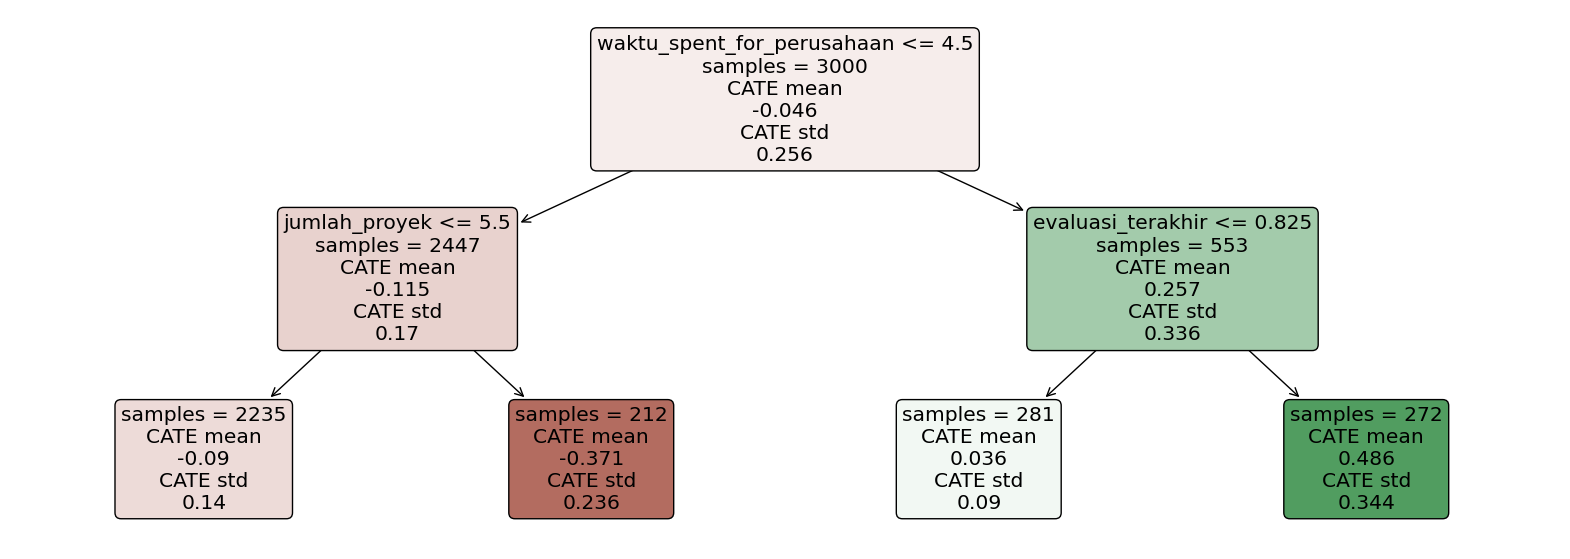

In [40]:
plt.figure(figsize=(20, 7))
causal.plot_heterogeneity_tree(
    X_test, "tingkat_kepuasan", max_depth=2, min_impurity_decrease=1e-7
)

#### Penasaran apa pengaruh dari konsep Sebab Akibat / Causal Effect yang sudah dibangun terhadap data yang baru (menggunakan default alpha).

Causal Effect secara global dan lokal terhadap data yang belum pernah dilihat

In [41]:
# secara global
causal.cohort_causal_effect(X_test)

,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,,,,,,
tingkat_kepuasan,-0.046077,0.134703,-0.342066,0.732301,-0.310090,0.217935
evaluasi_terakhir,0.045078,0.122653,0.367522,0.713230,-0.195317,0.285473
jumlah_proyek,0.001923,0.013966,0.137688,0.890487,-0.025449,0.029295
rata-rata_jam_bulan,0.000217,NaN,NaN,NaN,0.000217,0.000217
waktu_spent_for_perusahaan,0.018399,0.013583,1.354524,0.175569,-0.008224,0.045021


In [42]:
causal.local_causal_effect(X_test)

point    stderr     zstat   p_value  \
sample feature                                                              
0      tingkat_kepuasan           -0.280352  0.170565 -1.643672  0.100244   
       evaluasi_terakhir          -0.531210  0.392094 -1.354801  0.175481   
       jumlah_proyek              -0.010071  0.026189 -0.384542  0.700577   
       rata-rata_jam_bulan         0.000366  0.000638  0.573692  0.566177   
       waktu_spent_for_perusahaan  0.005699  0.005017  1.135850  0.256019   
...                                     ...       ...       ...       ...   
2999   tingkat_kepuasan           -0.053872  0.039075 -1.378669  0.167997   
       evaluasi_terakhir          -0.034415  0.084232 -0.408577  0.682850   
       jumlah_proyek               0.024040  0.009066  2.651590  0.008011   
       rata-rata_jam_bulan        -0.000083  0.000271 -0.304666  0.760620   
       waktu_spent_for_perusahaan -0.023325  0.014766 -1.579644  0.114188   

                                   ci_lower  ci_upper  
sample feature                                         
0      tingkat_kepuasan           -0.614653  0.053948  
       evaluasi_terakhir          -1.299700  0.237281  
       jumlah_proyek              -0.061400  0.041259  
       rata-rata_jam_bulan        -0.000884  0.001617  
       waktu_spent_for_perusahaan -0.004135  0.015532  
...                                     ...       ...  
2999   tingkat_kepuasan           -0.130458  0.022714  
       evaluasi_terakhir          -0.199507  0.130676  
       jumlah_proyek               0.006270  0.041810  
       rata-rata_jam_bulan        -0.000615  0.000449  
       waktu_spent_for_perusahaan -0.052266  0.005616  

[15000 rows x 6 columns]

#### Analisis Causal Effect secara Global
Tidak ada variabel fitur yang menunjukkan efek kausal signifikan secara statistik terhadap outcome y. Menunjukkan bahwa tidak ada bukti kuat untuk mengatakan bahwa fitur-fitur ini secara signifikan mempengaruhi outcome pada level populasi.

#### Analisis Causal Effect secara Lokal
Analisis kausal lokal memberikan estimasi efek kausal untuk setiap sampel individu dalam data tes.

- Beberapa sampel menunjukkan efek kausal yang signifikan, seperti **"jumlah proyek"** pada sample 2999. Menunjukkan bahwa ada variabilitas dalam efek kausal di antara individu-individu dalam dataset.

- Kebanyakan efek kausal pada level individu tidak signifikan secara statistik, namun konsisten dengan hasil global.


Meskipun analisis global menunjukkan bahwa tidak ada fitur yang signifikan, analisis lokal menunjukkan adanya variasi di tingkat individu. Sehingga perubahan dalam variabel tertentu mungkin memiliki dampak yang berbeda pada individu yang berbeda.